# Computer Vision Using PyTorch
Date: 2020-07-02  
Author: Jason Beach  
Categories: Cheatsheet, Data_Science  
Tags: pytorch, python, classification  
<!--eofm-->

The deep learning movement began by applying neural networks to image classification.  PyTorch became a leading framework for work in this field.  This post provides a cheatsheet to some of the basic methods used for computer vision, using PyTorch.

## Configuration

This is a typical environment setup.  Seed the Random Number Generator for all devices (both CPU and CUDA) using `manual_seed()` so that work can be reproduced.  Computations are deterministic only on your specific problem, platform, and PyTorch release.  See, [here](https://pytorch.org/docs/stable/notes/randomness.html), for more.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import torch

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

## Dataset

Popular datasets include: MNIST, FashionMNIST, CIFAR-100, SVHN, Coco, Omniglot.  The `torchvision` library has access to them.

In [2]:
from torchvision import datasets

cifar10 = datasets.CIFAR10('data', train=True, download=True)
cifar10_val = datasets.CIFAR10('data', train=False, download=True)

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [3]:
type(cifar10).__mro__

(torchvision.datasets.cifar.CIFAR10,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 object)

In [5]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
len(cifar10)                      #items in dataset
img, label = cifar10[99]     
img, label, class_names[label]    #image, label, label-name

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7F7DC113E358>,
 1,
 'automobile')

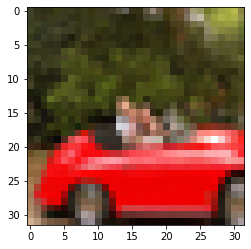

In [6]:
plt.imshow(img)
plt.show()

## Transform Pipelines

The following transforms are used in nearly every pipeline to prepare data for a model.

### ToTensor()

In [12]:
from torchvision import transforms
print(dir(transforms)[:20])

['CenterCrop', 'ColorJitter', 'Compose', 'FiveCrop', 'Grayscale', 'Lambda', 'LinearTransformation', 'Normalize', 'Pad', 'RandomAffine', 'RandomApply', 'RandomChoice', 'RandomCrop', 'RandomErasing', 'RandomGrayscale', 'RandomHorizontalFlip', 'RandomOrder', 'RandomPerspective', 'RandomResizedCrop', 'RandomRotation']


In [13]:
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

In [15]:
tensor_cifar10 = datasets.CIFAR10('data', train=True, download=False,
                                  transform=transforms.ToTensor()
                                 )

The original PIL image ranged from 0 to 255 (8-bit per channel), the ToTensor transform turned the data into 32-bit floating point per channel, scaling values down from 0.0 to 1.0. 

In [16]:
img_t.min(), img_t.max()

(tensor(0.), tensor(1.))

Must use permute to change the order of the axes from CxHxW to HxWxC to match what Matplotlib expects.

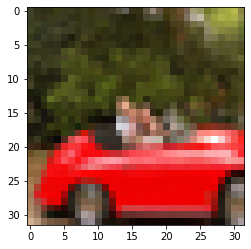

In [18]:
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

### Normalize()

Unfortunately, some manual work must be done to obtain the mean and stadard deviations used to normalize the data.

In [19]:
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)    #stack all tensors returned by the dataset along an extra dimension
print( imgs.shape )

imgs.view(3, -1).mean(dim=1)   #mean per channel
imgs.view(3, -1).std(dim=1)    #std per channel

torch.Size([3, 32, 32, 50000])


tensor([0.2470, 0.2435, 0.2616])

In [20]:
transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))
cifar10 = datasets.CIFAR10('data', train=True, download=False,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                   (0.2470, 0.2435, 0.2616))
                          ]))

In [22]:
cifar10_val = datasets.CIFAR10('data', train=False, download=False,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                   (0.2470, 0.2435, 0.2616))
                          ]))

This is because normalization has shifted the RGB levels outside the 0.0 to 1.0 range and changed the overall magnitudes of the channels. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


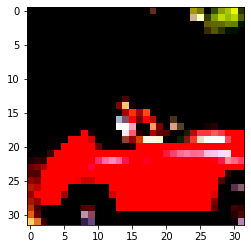

In [23]:
img_t, _ = cifar10[99]
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

## Fully-Connected, Feed-Forward Network

This is the most simple type of neural network.  We can use the `nn.Sequential` function to step through each layer of the network.

### Problem statement

Within the cifar10 dataset, we are only looking at items labelled 'birds' or 'planes'.

In [30]:
label_map = {0: 0, 2: 1}
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

Softmax is a monotone function, in that lower values in the input will correspond to lower values in the output.  However, it’s not "scale invariant", in that the ratio between values is not preserved. 

In [31]:
x = torch.tensor([1.0, 2.0, 3.0])
softmax = torch.nn.Softmax(dim=0)
softmax(x)

tensor([0.0900, 0.2447, 0.6652])

In [32]:
import torch.nn as nn

model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.Softmax(dim=1))

### Test design

Once a model is designed, it should be tested with the same input to ensure no problems.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


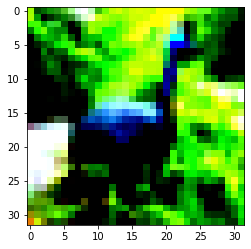

In [33]:
img, _ = cifar2[0]
plt.imshow(img.permute(1, 2, 0))
plt.show()

Elements are initialized randomly by PyTorch between -1.0 and 1.0, so don't be confused by the values.

In [34]:
img_batch = img.view(-1).unsqueeze(0)
out = model(img_batch)                  
out

tensor([[0.3700, 0.6300]], grad_fn=<SoftmaxBackward>)

The loss function associates a meaning to these two numbers, after back-propagation. If the labels are provided as index 0 for "airplane" and index 1 for "bird", than that’s the order the outputs will be induced to take. Therefore, after training we will be able to get the label as an index by computing the argmax of the output probabilities, that is, the index at which we get the maximum probability.

In [36]:
_, index = torch.max(out, dim=1)
index

tensor([1])

We want a loss function that is very high when the likelihood is low, that is, so low that the alternatives have a higher probability. Negative log likelihood (NLL) is a good candidate as it takes probabilities in input, so as the likelihood grows the other probabilities will necessarily decrease.  It has the expression: 

`NLL = - sum(log(out_i[c_i]))`, where the sum is taken over `N` samples and `c_i` is the correct class for sample `i`.

The `nn.NLLLoss` doesn’t take a logarithm of the likelihood, but it expects a tensor of log probabilities in input.  This is because taking a logarithm around 0 can create some VERY small numbers.  So, we must use `nn.LogSoftmax` instead of `nn.Softmax`, which takes care to make the calculation numerically stable. 

The combination of `nn.LogSoftmax` and `nn.NLLLoss` is equivalent to using `nn.CrossEntropyLoss`. In fact, the combined mathematical expression for taking the negative sum of log softmax of a vector of values corresponds to the mathematical expression for cross entropy. 

In [37]:
softmax = nn.Softmax(dim=1)
log_softmax = nn.LogSoftmax(dim=1)

x = torch.tensor([[0.0, 104.0]])
softmax(x)
print('softmax: ', torch.log(softmax(x)) )
print('log softmax: ', torch.exp(log_softmax(x)) )

softmax:  tensor([[-inf, 0.]])
log softmax:  tensor([[0., 1.]])


In [38]:
import torch.nn as nn

model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))    #instead of nn.Softmax(dim=1))

In [39]:
img_batch = img.view(-1).unsqueeze(0)
out = model(img_batch)                  
out

tensor([[-0.7372, -0.6509]], grad_fn=<LogSoftmaxBackward>)

The loss takes the output of nn.LogSoftmax for a batch as the first argument and a tensor of class indices (0’s and 1’s in our case) as the second argument. 

In [40]:
loss = nn.NLLLoss()
out = model(img.view(-1).unsqueeze(0))
loss(out, torch.tensor([label]))

tensor(0.6509, grad_fn=<NllLossBackward>)

### Train model

How we use records in training has important consequences.  An epoch ends when all samples in the training set have been evaluated.  But, this could be done in multiple ways: 
i) using ever observation in the dataset, then update the gradient (all obs)
ii) using ever observation in the dataset, and updating the gradient on each sample, or
iii) dividing the dataset into minibatches, for every minibatch, for every obs in minibatch, then update the gradient (all obs in minibatch)

By shuffling samples at each epoch and estimating the gradient on one or (preferably, for stability) a few samples at a time, we are effectively introducing randomness in our gradient descent. Remember SGD? It stands for Stochastic Gradient Descent, and this is what the S is about: working on small batches (aka minibatches) of shuffled data.  Using minibatches helps convergence and prevents the optimization process from getting stuck in local minima it encounters along the way.

Size of minibatches is another hyperparameter.  The job of a `torch.utils.data.DataLoader` is to sample minibatches from a Dataset, giving the flexibility to choose from different sampling strategies, a very common one being uniform sampling after shuffling the data at each epoch.

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 128),
            nn.Tanh(),
            nn.Linear(128, 2),
            nn.LogSoftmax(dim=1))

learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()
n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        #imgs will be a tensor of size 64x3x32x32
        #labels a tensor of size 64 containing label indices
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch == 1 or epoch % 10 == 0:
        print('Epoch {}, Training loss {}'.format(
            epoch, float(loss)))

Epoch 0, Training loss 0.5787188410758972
Epoch 1, Training loss 0.6271973848342896
Epoch 10, Training loss 0.19447796046733856
Epoch 20, Training loss 0.4353618323802948
Epoch 30, Training loss 0.17823220789432526
Epoch 40, Training loss 0.13526563346385956
Epoch 50, Training loss 0.09489273279905319
Epoch 60, Training loss 0.02850762940943241
Epoch 70, Training loss 0.01548031810671091
Epoch 80, Training loss 0.00986947026103735
Epoch 90, Training loss 0.009175573475658894


### Results

In [45]:
#training set
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.998200


In [46]:
#validation set
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.820000


High training accuracy with low test accuracy probably means over-fitting.

In [48]:
numel_list = [p.numel() for p in model.parameters() if p.requires_grad == True]
sum(numel_list), numel_list

(393602, [393216, 128, 256, 2])

The combination of nn.LogSoftmax and nn.NLLLoss is equivalent to using nn.CrossEntropyLoss.  The only gotcha that the output of our model will not be interpretable as probabilities (or log probabilities). We’ll need to explicitly pass the output through a softmax to obtain those. 

In [49]:
connected_model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

loss_fn = nn.CrossEntropyLoss()

In [50]:
numel_list = [p.numel() for p in connected_model.parameters() if p.requires_grad == True]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

## Convolutional Network

Computer vision techniques are dominated by convolutional neural networks because of their accuracy in image classification. The technique of image analysis and recognition, where the agriculture and weather features are extracted from the open-source satellites like LSAT to predict the future growth and yield of a particular land are being implemented.  With convolutions we achieve: locality and translation-invariance. 

### Working with the convolution

Here, we have a convolution layer: 3 input channels, 16 (arbitrary) output channgels, and 3x3, 2-dim kernel.  Expect a weight tensor sized the following way: we’ll have as many kernels, sized (n_input_channels)x3x3, as the number of output channels. That is, we expect the weight tensor to be sized (n_input_channels)x3x3x(n_output_channels), so 3x3x3x16. 

In [51]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

By default, PyTorch will skip pixels at the boundary, thereby producing images that are one half of the convolution kernel width (in our case, 3//2 = 1) smaller on each side. This explains why we’re missing two pixels in each dimension.

In [52]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))     #unsqueeze accounts for batch dimension
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

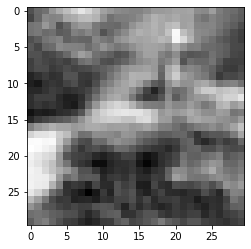

In [64]:
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

Here, we are using padding of 1 on the borders.  The size of weight and bias don’t change whether padding is used or not.

In [65]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

### Local average 

Blurring occurs because every pixel of the output is the average of a neighborhood of the input.

In [66]:
with torch.no_grad():
    conv.bias.zero_()
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

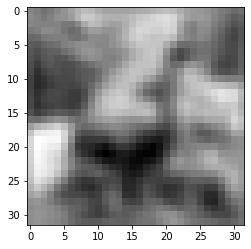

In [67]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

### Edge detection

Edge detection kernel: the kernel highlights the vertical edge between two horizontally adjacent regions.

In [ ]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
conv.bias.zero_()

From this angle, the job of a convolutional neural network is to estimate the kernel of a set of filter banks in successive layers, that will transform a multi-channel image into another multi-channel image, where different channels will correspond to different features (e.g. one channel for the average, another channel for vertical edges, etc).

### Pooling

Downsampling could in principle occur in different ways. Scaling an image by a half is the equivalent of taking 4 neighboring pixels in input and producing one pixel in output. How we compute the value of the output based on the values of the input is up to us. We could:

* Average the four pixels. This was a common approach early on, but has since fallen out of favor somewhat.
* Take the maximum of the four pixels (__Max Pooling__). This is currently the most commonly used approach, but has a downside of discarding the other 3/4ths of the data.
* Perform a strided convolution, where only every Nth pixel is calculated. A 3x4 convolution with stride 2 still incorporates input from all pixels from the previous layer. Current literature shows promise for this approach, but it has not yet supplanted maxpool.

Max-pooling is provided by the `nn.MaxPool2d` module.  It takes in input the size of the neighborhood over which to operate the pooling operation. If we wish to downsample our image by a half, we’ll want to use a size of 2.

In [68]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

### Build model

While using `nn.Sequential` may seem convenient, it is only capable for the most basic networks.  In order to make detailed modifications, we will have to create our own `nn.Module` subclasses.

In [69]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # WARNING: something missing here
            nn.Linear(512, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

sum([p.numel() for p in model.parameters()])

18090

In [ ]:
#This fails
model(img.unsqueeze(0))
#RuntimeError: size mismatch, m1: [64 x 8], m2: [512 x 32] at c:\...\THTensorMath.cpp:940

Looking back at the model the only module that has to have a 512 x 32 tensor is `nn.Linear(512, 32)`, the first linear module after the last convolution block.  What’s missing there is the reshaping step from a 8-channel 8x8 image to a 512-element, 1D vector (1D if we ignore the batch dimension, that is). This could be achieved by calling view on the output of the last `nn.MaxPool2d`, but unfortunately we don’t have any explicit visibility of the output of each module when we use `nn.Sequential`. 

The Net class is equivalent to the `nn.Sequential` model we built above in terms of submodules, but, by writing the forward function explicitly, we were able to manipulate the output of `self.pool3` directly and call view on it to turn it into a BxN vector. Note that we leave the batch dimension as -1 in the call to view, since in principle we don’t know how many samples there’ll be in the batch.

In [72]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()    
        #no matter how nested the submodule, any nn.Module can access the list of all child parameters. 
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act4 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)      #<<<<<new
        out = self.act4(self.fc1(out))
        out = self.fc2(out)
        return out

In [73]:
model = Net()

sum([p.numel() for p in model.parameters()])

18090

It appears a bit of a waste to register submodules that have no parameters, like `nn.Tanh` and `nn.MaxPool2d`. It would be easier to call them directly in the forward function.

It makes sense to keep using `nn` modules for `nn.Linear` and `nn.Conv2d`, so that Net will be able to manage their `Parameter`s (state) during training. However, we can safely switch to the functional counterparts of pooling and activation, since they have no parameters.

One may want to still initialize `nn.MaxPool2d` as we did before, to reinforce the fact that we’re using a kernel of 2. We could actually have just one instance of `nn.MaxPool2d` that we use everwhere - since `nn.MaxPool2d` has no parameters, `self.pool1`, `self.pool2` and `self.pool3` we initialized earlier were essentially the same thing and could be used interchangeably.

In more complex models getting the size of the first linear layer right is sometimes a source of frustration.  Creating a submodule can be helpful. 

In [74]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [75]:
model = Net()
model(img.unsqueeze(0))

tensor([[0.1432, 0.1911]], grad_fn=<AddmmBackward>)

In [76]:
import torch
import torch.nn as nn
import torch.nn.functional as F

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
    
model = Net()
learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs)
        loss = loss_fn(outputs, labels)
                
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch == 1 or epoch % 10 == 0:
        print('Epoch {}, Training loss {}'.format(
            epoch, float(loss)))

Epoch 0, Training loss 0.7593254446983337
Epoch 1, Training loss 0.40714699029922485
Epoch 10, Training loss 0.18846207857131958
Epoch 20, Training loss 0.08485838770866394
Epoch 30, Training loss 0.31306666135787964
Epoch 40, Training loss 0.25074532628059387
Epoch 50, Training loss 0.19872312247753143
Epoch 60, Training loss 0.08163115382194519
Epoch 70, Training loss 0.14351972937583923
Epoch 80, Training loss 0.1487308293581009
Epoch 90, Training loss 0.37778040766716003


In [77]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.890500


This only saves the parameters.  So you must ensure the model (submodule) definition is not changed when instantiating and loading the parameters (state).

In [ ]:
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

In [ ]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt'))

## Modifying Network Designs

We are interested in changing the details of the network, such as width (neurons) and depth (layers), as well as adding some nice features to reduce overfitting, such as:

_width_

* adaptive learning rate
* stopping criteria
* regularization: l1 (manual), l2 (`weight_decay`)
* dropout: `nn.Dropout*D`
* principled augmentation: `nn.BatchNorm*D`

_depth_

* skip connection: ResNet()
* identity mapping:

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [114]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, width=16):
        super(Net, self).__init__()
        self.width = width
        self.conv1 = nn.Conv2d(3, self.width, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(self.width, int(self.width/2), kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * int(self.width/2), int(self.width*2))
        self.fc2 = nn.Linear(int(self.width*2), 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * int(self.width/2))
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [119]:
model = Net(width=64)
model(img.unsqueeze(0))

tensor([[-0.1477, -0.0117]], grad_fn=<AddmmBackward>)

In [134]:
import torch
import torch.nn as nn
import torch.nn.functional as F

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
    
model = Net(width=32)
learning_rate = 1e-1
weight_decay=0.001
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_fn = nn.CrossEntropyLoss()
n_epochs = 100
stopping_criteria = 1e-05

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs)
        loss = loss_fn(outputs, labels)
        
        #l1
        #l1_lambda = 0.9
        #regularization_loss = 0
        #for param in model.parameters(): 
        #    regularization_loss += torch.sum(abs(param))
        #l1_norm = sum(abs(p) for p in model.parameters())
        #loss = loss + l1_lambda * regularization_loss

        #l2
        #optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001)
        #(or)
        #l2_lambda = 0.001
        #l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
        #loss = loss + l2_lambda * l2_norm
                
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch == 1 or epoch % 10 == 0:
        print('Epoch {}, Training loss {}'.format(
            epoch, float(loss)))
    if float(loss) < stopping_criteria:
        break

Epoch 0, Training loss 0.5520237684249878
Epoch 1, Training loss 0.31745433807373047
Epoch 10, Training loss 0.10780216008424759
Epoch 20, Training loss 0.12875433266162872
Epoch 30, Training loss 0.0402236171066761
Epoch 40, Training loss 0.003839320968836546
Epoch 50, Training loss 0.0046023111790418625
Epoch 60, Training loss 0.6562945246696472
Epoch 70, Training loss 0.0052324621938169
Epoch 80, Training loss 0.2878885567188263
Epoch 90, Training loss 0.005372203420847654


For modules that are only used during training, such as `nn.Dropout`, PyTorch lets us switch between the two modalities by calling `model.train()` or `model.eval()`.

In [138]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        model.eval()
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.912500


## Conclusion

This post can be a cheatsheet for basic neural network designs, such as the Feed Forward and Convolution Network.